# Cutler Poster Reproduction
Let's confirm that our pipeline is sound by reproducing the main analyses from the Cutler (2019) poster on this same dataset.

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from psifr import fr

# load recall data frame
data = pd.read_csv('data/psifr_sbs.csv')
events = fr.merge_free_recall(
    data, list_keys=['item_index', 'cycle', 'story_index', 
                     'story_name', 'time_test'])
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


## Recall Rates
Her first figure compared recall rates between immediate and delayed recall conditions, plotting a unique point for each subject in the dataset. 

In [2]:
recall_rates_by_timetest = events.pivot_table(
    index=['subject', 'time_test'], values='recall').reset_index()
recall_rates_by_timetest.head()

,subject,time_test,recall
0,0,1,0.427350
1,0,2,0.564103
2,0,3,0.380952
3,1,1,0.735043
4,1,2,0.880342


I have to figure out which timeTest columns she used for each condition. My hypothesis based on her methodology panel is that she used the second column for her 'immediate' condition and the third column for her 'delayed' condition.

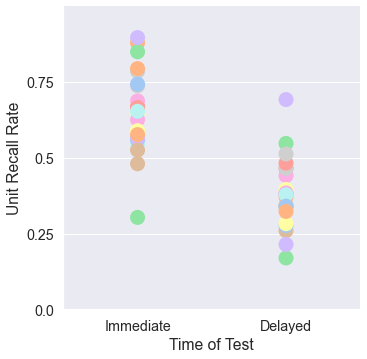

In [3]:
sns.set_theme(font_scale=1.3, style='darkgrid')

sns.catplot(
    x='time_test', y="recall", 
    data=recall_rates_by_timetest.loc[recall_rates_by_timetest.time_test > 1], 
        jitter=False, s=15, hue='subject', legend=False, palette='pastel');
plt.xticks(np.arange(2), ['Immediate', 'Delayed'])
plt.yticks(np.arange(0, 1, .25), np.arange(0, 1, .25))
plt.xlabel('Time of Test')
plt.ylabel('Unit Recall Rate')
plt.ylim([0, 1])
plt.show()

My hypothesis seems correct.

## Serial Position Curve

She rescaled the data as percentiles to enable generalization over story length. I suspect this was a bad idea. I'll focus on producing this plot per story. 

In [4]:
spc = events.query('study').pivot_table(
    index=['subject', 'story_name', 'time_test', 'input'], values=['recall']).reset_index()
spc.reset_index(level=0, inplace=True)
spc = spc.loc[spc.time_test > 1]
spc.head()

,index,subject,story_name,time_test,input,recall
40,40,0,Beach,2,1.0,True
41,41,0,Beach,2,2.0,True
42,42,0,Beach,2,3.0,True
43,43,0,Beach,2,4.0,True
44,44,0,Beach,2,5.0,False


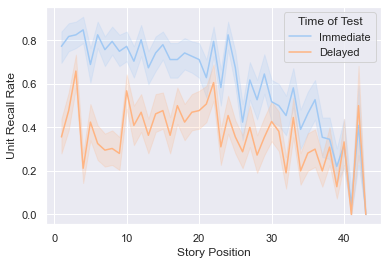

In [5]:
sns.set(style='darkgrid')
g = sns.lineplot(data=spc, x='input', y='recall', hue='time_test', palette='pastel')
plt.xlabel('Story Position')
plt.ylabel('Unit Recall Rate')
plt.legend(['Immediate', 'Delayed'], title='Time of Test');

We _do_ find a steady decline in performance across serial position at immediate test, but not at delayed test.

## Temporal Contiguity
She compared lag-CRPs for the immediate and delayed conditions, across stories and subjects. We'll aggregate outputs from the `fr.lag_crp` function in `psifr`.

In [6]:
lag_crps = []
for time_test in pd.unique(events.time_test):
    lag_crps.append(fr.lag_crp(events[events.time_test == time_test]))
    
lag_crp = pd.concat(
    lag_crps, keys=pd.unique(events.time_test), names=['time_test']).reset_index()

lag_crp = lag_crp.loc[lag_crp.time_test > 1]
lag_crp.head()

,time_test,subject,lag,prob,actual,possible
1870,2,0,-42.0,NaN,0,0
1871,2,0,-41.0,NaN,0,0
1872,2,0,-40.0,NaN,0,0
1873,2,0,-39.0,NaN,0,0
1874,2,0,-38.0,NaN,0,0


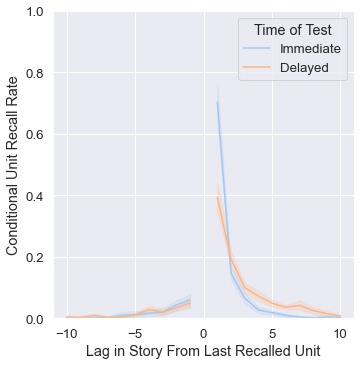

In [7]:
sns.set_theme(font_scale=1.2, style="darkgrid")

max_lag = 10
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(lag_crp, height=5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='time_test', palette='pastel', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='time_test', palette='pastel', **kws)
)
g.set_xlabels('Lag in Story From Last Recalled Unit')
g.set_ylabels('Conditional Unit Recall Rate')
plt.legend(['Immediate', 'Delayed'], title='Time of Test')
g.set(ylim=(0, 1));

## Semantic Similarity Matrix
First we need to apply a similarity metric close enough to that of the Cutler poster to reproduce the representational similarity matrices she visualized. She reports that she used the GloVe semantic vector space model and focused analysis on "content words", presumably excluding stop words as tracked in packages like `nltk` and `spacy`.

In [8]:
units = events.pivot_table(index=['story_name', 'input'], values='item', aggfunc='first').reset_index()
units.head()

,story_name,input,item
0,Beach,1.0,"It was a hot, sunny day"
1,Beach,2.0,and Kaylie and Rachel
2,Beach,3.0,decided to take advantage of their off day
3,Beach,4.0,and take a trip to the beach.
4,Beach,5.0,"The sun was an optimistic yellow pellet,"


In [9]:
from sentence_transformers import SentenceTransformer, util
import spacy

nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words

# paraphrase-MiniLM-L12-v2
# average_word_embeddings_glove.6B.300d
# average_word_embeddings_glove.840B.300d
# stsb-distilbert-base
model = SentenceTransformer('average_word_embeddings_glove.840B.300d') 
connections = {}
remove_stopwords = False

for story_name in ['Fisherman', 'Supermarket', 'Flight', 'Cat', 'Fog', 'Beach']:
    
    sentences = units.loc[units.story_name==story_name].item.values.tolist()
    
    clean_sentences = []
    for i in range(len(sentences)):
        if remove_stopwords:
            text_token = nlp(sentences[i])
            clean_sentences.append(' '.join([word.text for word in text_token if not word.is_stop]))
        else:
            clean_sentences.append(sentences[i])
    
    #Compute embeddings
    embeddings = model.encode(clean_sentences, convert_to_tensor=True)

    #Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = np.abs(util.pytorch_cos_sim(embeddings, embeddings).numpy())
    cosine_scores[np.eye(len(cosine_scores), dtype='bool')] = np.nan
    connections[story_name] = cosine_scores

# Let's take a peek at the ranges of these similarity scores.
# Technically, they should never be below 0, but norming is always an option.
for story_name in connections.keys():
    print(story_name)
    print(np.nanmax(connections[story_name]), np.nanmin(connections[story_name]))

Fisherman
0.8932854 0.1713925
Supermarket
0.9049896 0.010644902
Flight
0.82337046 0.00011601392
Cat
0.9280014 0.0004547797
Fog
0.90356845 0.001980994
Beach
0.7947867 0.0010127202


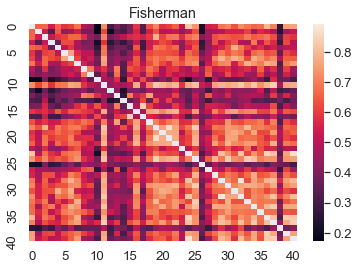

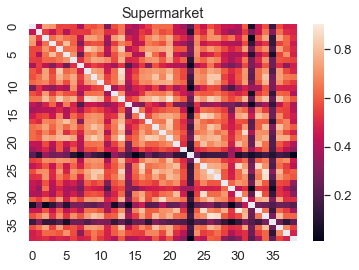

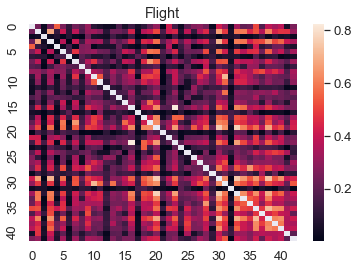

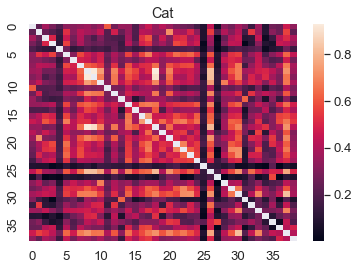

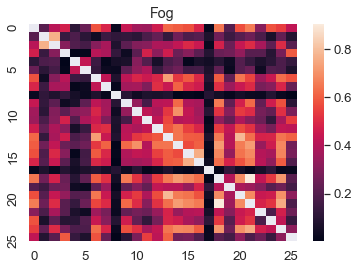

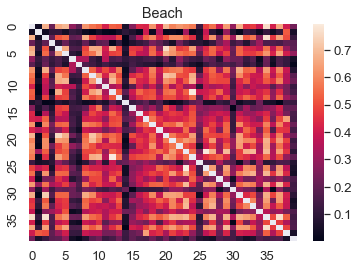

In [10]:
for story_name in connections.keys():
    
    sns.heatmap(connections[story_name], xticklabels=5, yticklabels=5)
 #   print(np.nanmean(connections[story_name], axis=1))
    plt.title(story_name)
    plt.show()

The patterns in this matrix seem to be highly sensitive to the STS metric applied. And whether you filter for content words seems to have a meaningful impact, too.

Eyeballing these plots suggests that the matrices in Becky's paper were from the Fog and Fisherman story facets, respectively. However, whether I remove stopwords or not, there doesn't see to be any one-to-one accord for any of these matrices.

## Recall benefit for idea units that are more semantically similar to other idea units in the narrative
It looks like for each idea unit across all stories, I need either a mean or summed similarity to every other relevant idea unit, along with its mean recall probability across subjects, split between time_test values. Plot the result and a line of best fit. Should see a nonsignificant positive relationship in the delayed condition but not the immediate.

In [11]:
connection_strengths = {}
for story_name in connections.keys():
    connection_strengths[story_name] = np.nanmean(connections[story_name], axis=1)

strengths_df = events.pivot_table(
    index=['story_name', 'time_test', 'input'], values='recall').reset_index()
strengths_df['cosine_similarity'] = np.nan

for story_name in pd.unique(events.story_name):
    for time_test in range(1, 4):
        for input in range(1, len(connection_strengths[story_name])+1):
            if len(strengths_df.loc[(strengths_df.story_name == story_name) & (
                strengths_df.time_test == time_test) & (strengths_df.input == input)]) == 1:

                strengths_df.loc[(strengths_df.story_name == story_name) & (
                    strengths_df.time_test == time_test) & (
                        strengths_df.input == input), 'cosine_similarity'] = connection_strengths[story_name][input-1]

strengths_df.head()

,story_name,time_test,input,recall,cosine_similarity
0,Beach,1,1.0,0.954545,0.465404
1,Beach,1,2.0,0.818182,0.102658
2,Beach,1,3.0,0.954545,0.428772
3,Beach,1,4.0,0.454545,0.150023
4,Beach,1,5.0,0.363636,0.435155


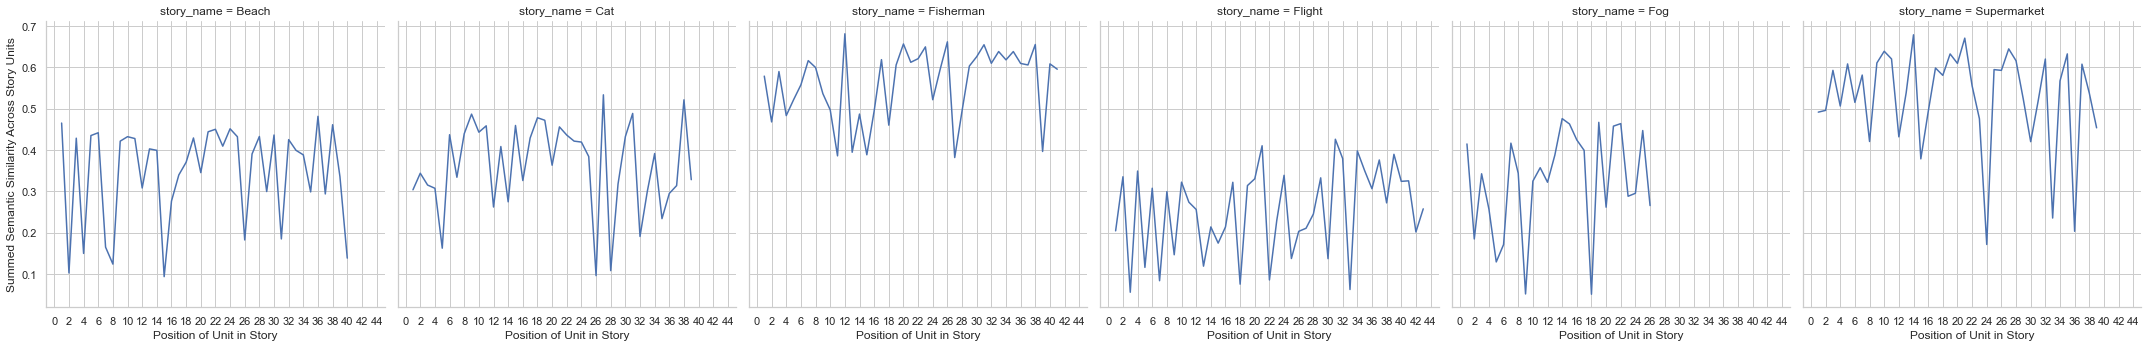

In [12]:
sns.set(style='whitegrid')
g = sns.FacetGrid(strengths_df.loc[strengths_df.time_test == 1], 
    col='story_name', height=5)
g.map_dataframe(sns.lineplot, 'input', 'cosine_similarity');
g.set_ylabels('Summed Semantic Similarity Across Story Units')
g.set_xlabels('Position of Unit in Story')
g.set(xticks=np.arange(0, 46, 2))
plt.show()

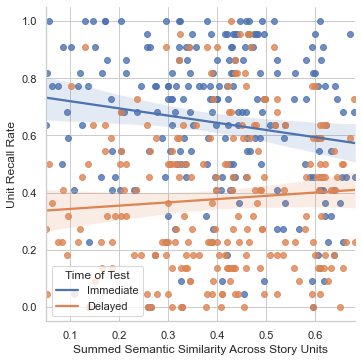

In [13]:
sns.set_theme(style='whitegrid')
    
sns.lmplot(data=strengths_df.loc[strengths_df.time_test > 1], 
    x="cosine_similarity", y="recall", palette="deep", hue='time_test', legend=False);
plt.ylabel('Unit Recall Rate');
plt.xlabel('Summed Semantic Similarity Across Story Units')
plt.legend(['Immediate', 'Delayed'], title='Time of Test');

## Semantic CRP
This wasn't in the original poster, but is a natural extension.

The `psifr` library's `fr.distance_crp` function sorts distances into bins and then applies a lag_rank analysis to the result apparently. What's best practice for bin sorting? Cover the whole score range, size so a large enough sample is in each pool?

In [14]:
sem_crps = []

# choose bins for CRP
bin_size = .1
np.arange(0, 1 + bin_size, bin_size)
edges = np.arange(0, 1 + bin_size, bin_size)

# build list of sem_crps across each factor i'm interested
for time_test in pd.unique(events.time_test):
    for story_name in pd.unique(events.story_name):
        subset = events.loc[(events.time_test == time_test) & (
            events.story_name == story_name)]
        dcrp = fr.distance_crp(
            subset, 'item_index', connections[story_name], edges)
        dcrp['story_name'] = story_name
        if time_test == 1:
            dcrp['time_test'] = 1
        elif time_test == 2:
            dcrp['time_test'] = 'immediate'
        else:
            dcrp['time_test'] = 'delayed'
        sem_crps.append(dcrp)
    
sem_crp = pd.concat(sem_crps).reset_index()
sem_crp = sem_crp.loc[sem_crp.time_test != 1]
sem_crp = sem_crp.pivot_table(index=['time_test', 'subject', 'center'], values='prob').reset_index()
sem_crp

,time_test,subject,center,prob
0,delayed,0,0.05,0.014291
1,delayed,0,0.15,0.030525
2,delayed,0,0.25,0.014154
3,delayed,0,0.35,0.038029
4,delayed,0,0.45,0.026258
...,...,...,...,...
434,immediate,21,0.55,0.034907
435,immediate,21,0.65,0.053336
436,immediate,21,0.75,0.045069
437,immediate,21,0.85,0.031250


(0.0, 0.2)

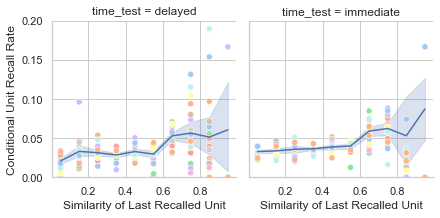

In [15]:
g = sns.FacetGrid(data=sem_crp, col='time_test')
g.map_dataframe(sns.lineplot, x='center', y='prob')
g.map_dataframe(sns.scatterplot, x='center', y='prob', hue='subject', palette='pastel')
g.set_xlabels('Similarity of Last Recalled Unit')
g.set_ylabels('Conditional Unit Recall Rate');
plt.ylim([0, .2])

So the semantic CRP analysis is really noisy even when we include data from all stories. Standard deviation also seems to vary as semantic similarity increases, particularly in the delayed condition. That's the definition heteroskedasticity, right? I have no idea what the significance of that observation might be though. And the shape of this curve seems to depend substantially on the analysis anyway. I might end up concluding that I simply need more data. Will need some reflection about why though. In the meantime, let's clarify these analyses.